In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.base import clone
from sklearn import datasets
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from utils import *
from time import time
import os
from IPython.display import display, Latex
from tabulate import tabulate
%load_ext autoreload
%autoreload 2

%matplotlib inline


#change directory to save output here
directory = r"D:\Users\Nick\Desktop\Everything\Uni\Honours Project\Plots\SVM_reg/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(directory))

C:\Users\nickb\AppData\Local\Temp/ipykernel_15536/4068729799.py:32: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(directory))


In [2]:
RQA_df = pd.read_csv(r"D:\Users\Nick\Desktop\Everything\Uni\Honours Project\rqa_data\RQA_Rossler_y-RQA-Parameters-true_0.02_max_3_2_4_2.csv")

print("- shape is", RQA_df.shape)

display(RQA_df)

- shape is (25100, 15)


,a,DIV,LAM,Vmax,VENTR,Lmax,MRT,NMPRT,RR,RTE,TT,L,ENTR,DET,TREND
0,0.30,0.003891,0.000000,0,NaN,257,44.676294,892,0.020425,1.172377,0.000000,65.800000,2.171571,0.912200,-0.019061
1,0.30,0.003891,0.000000,0,NaN,257,44.777112,888,0.020425,1.178569,0.000000,65.600000,2.079151,0.909427,-0.019769
2,0.30,0.003891,0.000000,0,NaN,257,44.569482,890,0.020425,1.171830,0.000000,65.800000,2.118649,0.912200,-0.020108
3,0.30,0.003891,0.000000,0,NaN,257,44.445172,885,0.020406,1.175427,0.000000,65.466667,1.898927,0.908418,-0.022051
4,0.30,0.003891,0.000000,0,NaN,257,44.602291,885,0.020406,1.178209,0.000000,65.466667,1.898927,0.908418,-0.022051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25095,0.55,0.029412,0.282002,5,0.447831,34,52.508014,109,0.019613,4.095970,2.154412,6.750000,2.401185,0.805582,0.024333
25096,0.55,0.020408,0.246908,3,0.247725,49,49.614058,169,0.019840,3.567998,2.067729,8.053571,2.595439,0.858230,0.005989
25097,0.55,0.031250,0.246356,6,0.752440,32,46.524205,232,0.019424,3.811100,2.336406,6.391608,2.461300,0.888241,0.001964
25098,0.55,0.016949,0.257737,4,0.731423,59,50.281926,142,0.019519,3.895217,2.348018,6.664062,2.393025,0.824952,-0.016217


In [3]:
RQA_df=RQA_df.fillna(0)

#Rearranging columns into diagonal -> vertical -> recurrence type features
cols = ["a","DET","L","Lmax","DIV","ENTR","TREND","LAM","TT","Vmax","VENTR","RR","MRT","NMPRT","RTE"]
RQA_df=RQA_df[cols]
feature_set=RQA_df.loc[:, RQA_df.columns != 'a']



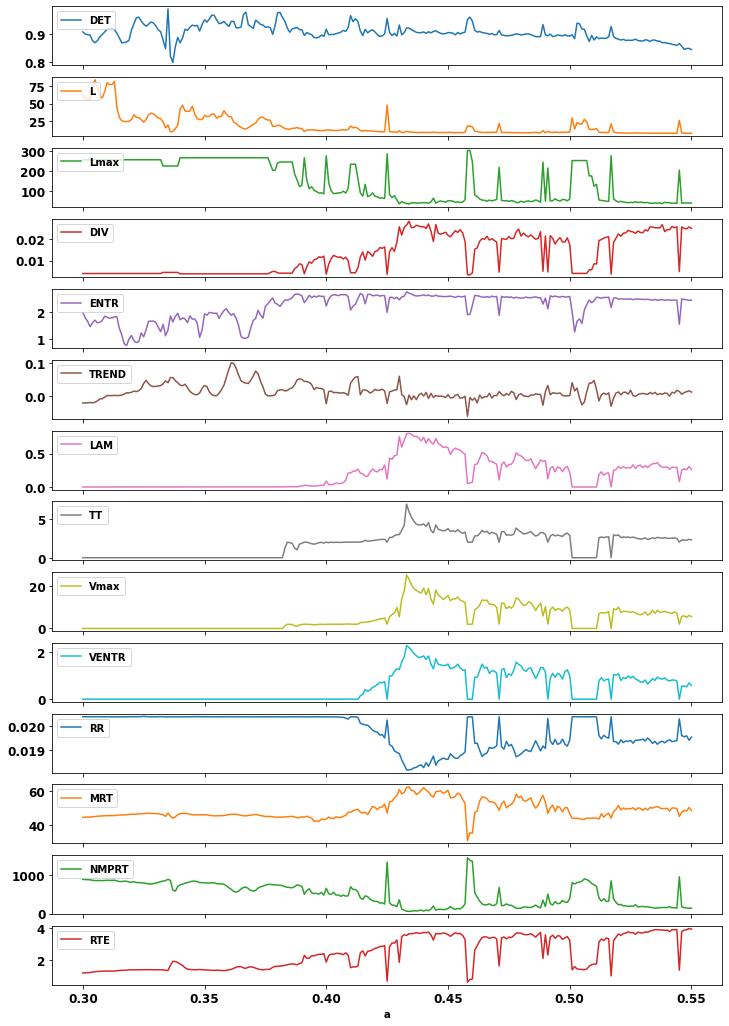

In [4]:
#MRT = Mean Recurrence Time
#NMPRT = Number for Most Probable Recurrence Time
#RTE = Recurrence Time Entropy
RQA_meanvals=RQA_df.groupby(np.arange(len(feature_set))//100).mean()

axes=RQA_meanvals.plot(x="a",subplots=True,figsize=(12,18),fontsize=12)
axes = axes.flat
fig = axes[0].get_figure()
for ax in axes:
    
    ax.legend(loc='upper left')



plt.show()

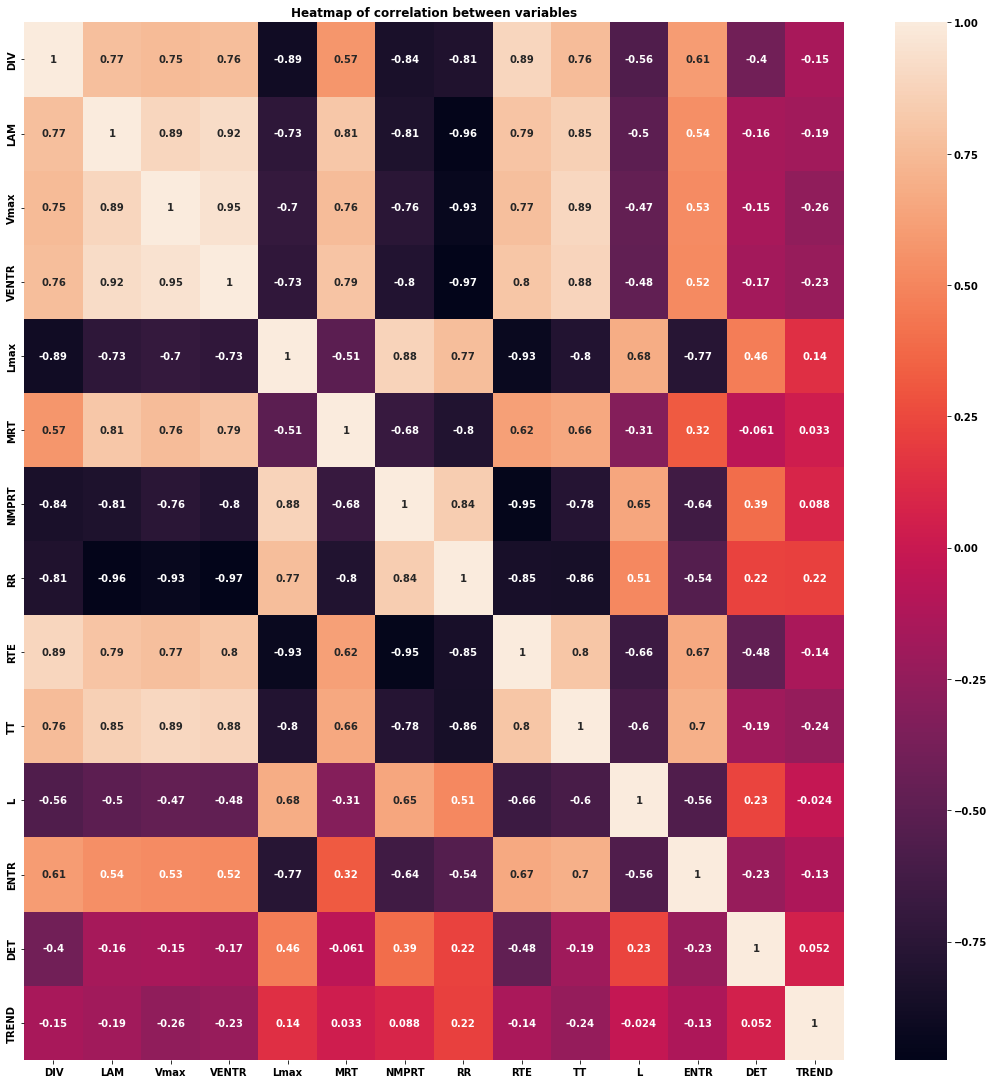

In [129]:
#Pearson Correlation

cm = np.corrcoef(feature_set.values.T)
fig, ax = plt.subplots(figsize=(15,15))
plt.tight_layout()
plt.title("Heatmap of correlation between variables")
sns.heatmap(cm,annot=True,xticklabels=feature_set.columns,yticklabels=feature_set.columns,ax=ax)
plt.show()

In [4]:
#to test with smaller data set, save time, 1 = WHOLE DATA SET
test_set = feature_set.iloc[::1]
target = RQA_df.iloc[::1]["a"]


In [5]:
var_train, var_test,target_train, target_test = train_test_split(test_set,target,test_size=0.3,
                                                                   random_state=1, stratify = target)

In [6]:
sc=StandardScaler()
sc.fit(var_train)
var_train_std = sc.transform(var_train)
var_test_std = sc.transform(var_test)




In [7]:
tic = time()

#verbose = 1
#n_jobs = -1
param_grid = {"C":[0.01,0.1,1,10],
             "gamma":["scale","auto"],
             "epsilon":[0.1,0.0001,0.00001],
             "kernel":['linear','poly','rbf']}
svr=SVR()
search = GridSearchCV(estimator = svr, param_grid=param_grid, scoring = "r2",refit=False,verbose=2,n_jobs = -1)
search.fit(var_train_std,target_train)

results_df = pd.DataFrame(search.cv_results_)


elapsed = time()-tic
print("- Elapsed time:")
print("%.4f (s)"%(elapsed))
print("%.4f (min)"%(elapsed/60))
print("%.4f (h)"%(elapsed/(60*60)))





Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ....C=0.01, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.01, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.01, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.01, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.01, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.01, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=0.01, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=0.01, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=0.01, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=0.01, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .......C=0.01, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.01, epsilon=0.1, gamma=scal

[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ........C=0.1, epsilon=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, eps

[CV] END ....C=1, epsilon=0.0001, gamma=scale, kernel=linear; total time= 3.5min
[CV] END ....C=1, epsilon=0.0001, gamma=scale, kernel=linear; total time= 3.4min
[CV] END ....C=1, epsilon=0.0001, gamma=scale, kernel=linear; total time= 3.5min
[CV] END ....C=1, epsilon=0.0001, gamma=scale, kernel=linear; total time= 3.5min
[CV] END ....C=1, epsilon=0.0001, gamma=scale, kernel=linear; total time= 3.3min
[CV] END ......C=1, epsilon=0.0001, gamma=scale, kernel=poly; total time= 2.5min
[CV] END ......C=1, epsilon=0.0001, gamma=scale, kernel=poly; total time= 2.3min
[CV] END ......C=1, epsilon=0.0001, gamma=scale, kernel=poly; total time= 2.2min
[CV] END ......C=1, epsilon=0.0001, gamma=scale, kernel=poly; total time= 2.4min
[CV] END ......C=1, epsilon=0.0001, gamma=scale, kernel=poly; total time= 2.5min
[CV] END .......C=1, epsilon=0.0001, gamma=scale, kernel=rbf; total time=  35.3s
[CV] END .......C=1, epsilon=0.0001, gamma=scale, kernel=rbf; total time=  35.1s
[CV] END .......C=1, epsilon

[CV] END ......C=10, epsilon=0.0001, gamma=scale, kernel=rbf; total time= 2.8min
[CV] END ......C=10, epsilon=0.0001, gamma=scale, kernel=rbf; total time= 2.8min
[CV] END ......C=10, epsilon=0.0001, gamma=scale, kernel=rbf; total time= 2.7min
[CV] END ....C=10, epsilon=0.0001, gamma=auto, kernel=linear; total time=23.3min
[CV] END ....C=10, epsilon=0.0001, gamma=auto, kernel=linear; total time=22.5min
[CV] END ....C=10, epsilon=0.0001, gamma=auto, kernel=linear; total time=22.6min
[CV] END ....C=10, epsilon=0.0001, gamma=auto, kernel=linear; total time=21.8min
[CV] END ....C=10, epsilon=0.0001, gamma=auto, kernel=linear; total time=23.1min
[CV] END ......C=10, epsilon=0.0001, gamma=auto, kernel=poly; total time=16.3min
[CV] END ......C=10, epsilon=0.0001, gamma=auto, kernel=poly; total time=15.9min
[CV] END ......C=10, epsilon=0.0001, gamma=auto, kernel=poly; total time=14.8min
[CV] END ......C=10, epsilon=0.0001, gamma=auto, kernel=poly; total time=15.9min
[CV] END ......C=10, epsilon

In [9]:
dd=results_df.sort_values(by=["rank_test_score"])
gridsearch_table=dd[["param_kernel","param_C","param_epsilon","param_gamma","mean_test_score","rank_test_score"]]
gridsearch_headers = ["kernel","C","epsilon","gamma","Mean test score","Rank"]
print(tabulate(gridsearch_table,headers=gridsearch_headers,tablefmt="latex_raw"))

\begin{tabular}{rlrrlrr}
\hline
    & kernel   &     C &   epsilon & gamma   &   Mean test score &   Rank \\
\hline
 62 & rbf      & 10    &    0.0001 & scale   &          0.965289 &      1 \\
 65 & rbf      & 10    &    0.0001 & auto    &          0.965282 &      2 \\
 68 & rbf      & 10    &    1e-05  & scale   &          0.965263 &      3 \\
 71 & rbf      & 10    &    1e-05  & auto    &          0.965242 &      4 \\
 44 & rbf      &  1    &    0.0001 & scale   &          0.960367 &      5 \\
 47 & rbf      &  1    &    0.0001 & auto    &          0.960354 &      6 \\
 50 & rbf      &  1    &    1e-05  & scale   &          0.96035  &      7 \\
 53 & rbf      &  1    &    1e-05  & auto    &          0.960336 &      8 \\
 26 & rbf      &  0.1  &    0.0001 & scale   &          0.944058 &      9 \\
 32 & rbf      &  0.1  &    1e-05  & scale   &          0.944047 &     10 \\
 29 & rbf      &  0.1  &    0.0001 & auto    &          0.944024 &     11 \\
 35 & rbf      &  0.1  &    1e-05  & 

In [8]:
search.best_params_

{'C': 10, 'epsilon': 0.0001, 'gamma': 'scale', 'kernel': 'rbf'}

In [7]:
#choose parameters + kernel

C = 10
epsilon = 0.0001
gamma="scale"
kernel = "rbf"

#SVM
svr = svm.SVR(kernel=kernel,gamma=gamma,epsilon=epsilon,C=C)
svr.fit(var_train_std,target_train)

SVR(C=10, epsilon=0.0001)

- Elapsed time:
1462.8590 (s)
24.3810 (m)
0.4063 (h)


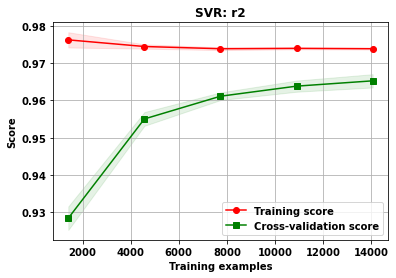

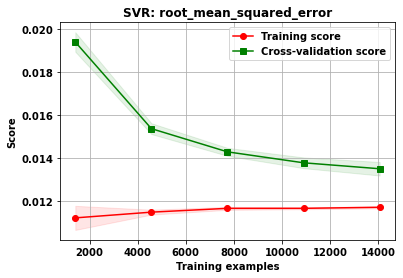

In [8]:
tic = time()

#change scoring here, Scikit convention is that higher scores are better, hence scoring input is the negative errors
#in utils.py, the negative RMSE/absolute error are multiplied by -1 to give their positive values
scoring=["r2","neg_root_mean_squared_error"]

titles = ["r2","root_mean_squared_error"]


i=0
for x in scoring:
    plot_learning_curve_save(estimator=svr,title="SVR:"+" "+titles[i],X=var_train_std,y=target_train,
                             n_jobs =-1,scoring=scoring[i],cv=5)
    i+=1

elapsed = time()-tic
print("- Elapsed time:")
print("%.4f (s)"%(elapsed))
print("%.4f (m)"%(elapsed/60))
print("%.4f (h)"%(elapsed/(60*60)))


- Elapsed time:
154.5473 (s)
2.5758 (min)
0.0429 (h)


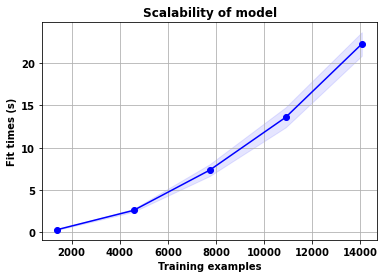

In [9]:
score="r2"
tic=time()

plot_fit_times_curve(svr,title="Scalability of model",X=var_train,y=target_train,
                             n_jobs =-1,scoring=score,cv=5)

elapsed = time()-tic
print("- Elapsed time:")
print("%.4f (s)"%(elapsed))
print("%.4f (min)"%(elapsed/60))
print("%.4f (h)"%(elapsed/(60*60)))

In [8]:
#Sorting standardised data set by 'a' values so that predictions can be done for different dynamic regimes

target_trainlist=target_train.tolist()
var_train_std_df = pd.DataFrame(var_train_std)
var_train_std_df.insert(loc=0,column="a",value=target_trainlist)

target_testlist = target_test.tolist()
var_test_std_df = pd.DataFrame(var_test_std)
var_test_std_df.insert(loc=0,column="a",value=target_testlist)

In [9]:
var_train_std_df=var_train_std_df.sort_values(by="a")
target_train = target_train.sort_index()


var_test_std_df=var_test_std_df.sort_values(by="a")
target_test = target_test.sort_index()

In [10]:
#chaos1 = spiral
#chaos2 = screw

svr_predict_train = svr.predict(var_train_std_df.drop(["a"],axis=1))
svr_periodic_predict = svr.predict(var_train_std_df.drop(["a"],axis=1)[:5810])
svr_chaos1_predict = svr.predict(var_train_std_df.drop(["a"],axis=1)[5810:9240])
svr_chaos2_predict = svr.predict(var_train_std_df.drop(["a"],axis=1)[9240:])

In [11]:
np.save("SVM_TRAIN_PREDICTION",svr_predict_train)
np.save("SVM_TRAIN_TARGET",target_train)

In [12]:
#squared = False means RMSE


rmse_periodic = mean_squared_error(target_train[:5810],svr_periodic_predict,squared=False)
rmse_chaos1 = mean_squared_error(target_train[5810:9240],svr_chaos1_predict,squared=False)
rmse_chaos2 = mean_squared_error(target_train[9240:],svr_chaos2_predict,squared=False)

svr_r2 = svr.score(var_train_std_df.drop(["a"],axis=1),target_train)
rmse_all = mean_squared_error(target_train,svr_predict_train,squared=False) 




In [13]:
string_r2 = str(np.round(svr_r2,6))
string_rmse = str(np.round(rmse_all,6))

string_periodic = str(np.round(rmse_periodic,6))
string_chaos1 = str(np.round(rmse_chaos1,6))
string_chaos2 = str(np.round(rmse_chaos2,6))

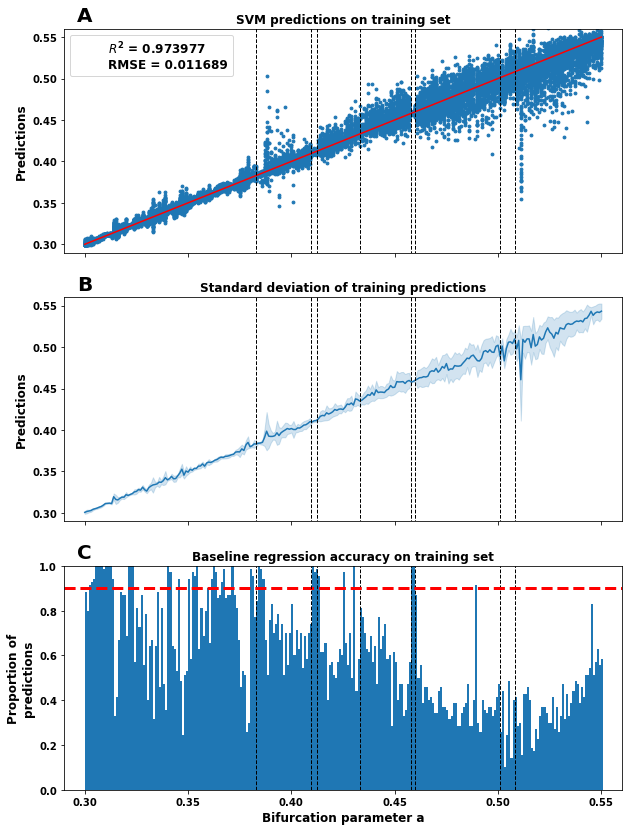

In [22]:
import matplotlib.patches as mpatches

fig, (ax1, ax3,ax2) = plt.subplots(3, 1, figsize=(10, 14),
                               sharex=True)


ax1.text(0.05, 1.1, "A", transform=ax1.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')
ax2.text(0.05, 1.1, "C", transform=ax2.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')
ax3.text(0.05, 1.1, "B", transform=ax3.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')


#Training prediction plot
ax1.scatter(target_train,svr_predict_train,s=8)
ax1.plot(target_train,target_train,color="r")
ax1.set_ylabel("Predictions",fontsize=12)
ax1.set_title("SVM predictions on training set",fontsize=12)
ax1.set_ylim([0.29,0.56])
plt.xlim([0.29,0.56])

plt.rcParams["legend.fontsize"] = 12
my_patch = mpatches.Patch(label = " ".join(["$R^2$","=",string_r2]) + "\n"+ " ".join(["RMSE","=",string_rmse])
                         , color="w")
ax1.legend(handles=[my_patch])

ax1.plot([0.43295,0.43295],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.383,0.383],[0,0.58],"k",linestyle="--",linewidth=1)

ax1.plot([0.458,0.458],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.46,0.46],[0,0.58],"k",linestyle="--",linewidth=1)

ax1.plot([0.501,0.501],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.508,0.508],[0,0.58],"k",linestyle="--",linewidth=1)

#Proportion of above baseline prediction plot

trainarray = target_train.to_numpy(copy=True)
trainarray_sort = np.sort(trainarray)

good_vals = []
a_vals = []
for i in range(0,trainarray.size):
    if trainarray[i]-0.01*trainarray[i] <= svr_predict_train[i] <= trainarray[i]+0.01*trainarray[i]:
        good_vals.append(svr_predict_train[i])
        a_vals.append(trainarray[i])


series_a=pd.Series(a_vals)
sorted_series_a=series_a.sort_values()

num = 0
values = sorted_series_a.value_counts(sort=False).keys().tolist()
counts = sorted_series_a.value_counts(sort=False).tolist()
for ii in trainarray_sort[::70]:
    if ii not in values:
        values.insert(num,ii)
        counts.insert(num,0)
    num+=1
    
countarray = np.array(counts)

ax2.bar(values,countarray/70,width=0.001,align='edge')
ax2.set_ylim([0,1])

divcountarray = countarray/70

ax2.plot([0.43295,0.43295],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.383,0.383],[0,1],"k",linestyle="--",linewidth=1)


ax2.plot([0.458,0.458],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.46,0.46],[0,1],"k",linestyle="--",linewidth=1)

ax2.plot([0.501,0.501],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.508,0.508],[0,1],"k",linestyle="--",linewidth=1)


#my_patch = mpatches.Patch(label = " ".join(["$a$ < $a_{spiral}$","=",str(np.round(np.mean(divcountarray[:83]),3))])
                          #+ "\n"+ " ".join(["$a_{spiral}$ < $a$ < $a_{screw}$","=",str(np.round(np.mean(divcountarray[83:132]),3))]) 
                          #+ "\n" + " ".join(["$a > a_{screw}$","=",str(np.round(np.mean(divcountarray[132:]),3))])
                          #, color="w",fill=False)
#box=ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#plt.legend(handles=[my_patch],loc='center left', bbox_to_anchor=(1, .9))

ax2.set_ylabel("Proportion of"+"\n"+"predictions",fontsize = 12)
ax2.set_title("Baseline regression accuracy on training set")
ax2.plot([0.29,0.56],[0.9,0.9],"r",linewidth=3,linestyle="--")

#Standard deviation plot

df_SVR_train = pd.DataFrame()
df_SVR_train["True"] = target_train
df_SVR_train["Predicted"] = svr_predict_train


ci="sd"

ax3.set_title("Standard deviation of training predictions",fontsize=12)
sns.lineplot(x="True", y="Predicted",color="C0", ci=ci, data=df_SVR_train, ax=ax3)
ax2.set_xlabel("Bifurcation parameter a",fontsize=12)
ax3.set_ylabel("Predictions",fontsize=12)

ax3.set_xlim([0.29,0.56])
ax3.set_ylim([0.29,0.56])


ax3.plot([0.43295,0.43295],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.383,0.383],[0,1],"k",linestyle="--",linewidth=1)


ax3.plot([0.458,0.458],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.46,0.46],[0,1],"k",linestyle="--",linewidth=1)

ax3.plot([0.501,0.501],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.508,0.508],[0,1],"k",linestyle="--",linewidth=1)


ax1.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax1.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)

ax2.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)

ax3.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)

plt.savefig("SVR_training_results.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [16]:
svr_predict_test = svr.predict(var_test_std_df.drop(["a"],axis=1))
svr_periodic_predict_test = svr.predict(var_test_std_df.drop(["a"],axis=1)[:2490])
svr_chaos1_predict_test = svr.predict(var_test_std_df.drop(["a"],axis=1)[2490:3960])
svr_chaos2_predict_test = svr.predict(var_test_std_df.drop(["a"],axis=1)[3960:])

In [17]:
np.save("SVM_TEST_PREDICTION",svr_predict_test)
np.save("SVM_TEST_TARGET",target_test)

In [18]:
rmse_periodic_test = mean_squared_error(target_test[:2490],svr_periodic_predict_test,squared=False)
rmse_chaos1_test = mean_squared_error(target_test[2490:3960],svr_chaos1_predict_test,squared=False)
rmse_chaos2_test = mean_squared_error(target_test[3960:],svr_chaos2_predict_test,squared=False)

svr_r2_test = svr.score(var_test_std_df.drop(["a"],axis=1),target_test)
rmse_all_test = mean_squared_error(target_test,svr_predict_test,squared=False) 



In [19]:
test_string_r2 = str(np.round(svr_r2_test,6))
test_string_rmse = str(np.round(rmse_all_test,6))

test_string_periodic = str(np.round(rmse_periodic_test,6))
test_string_chaos1 = str(np.round(rmse_chaos1_test,6))
test_string_chaos2 = str(np.round(rmse_chaos2_test,6))

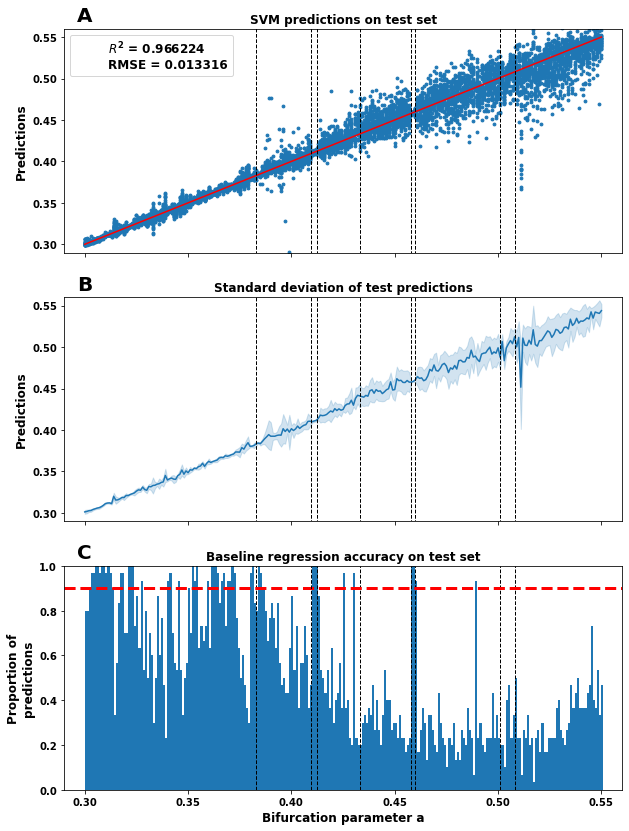

In [24]:
fig,(ax1,ax3,ax2)=plt.subplots(3,1,figsize=(10,14),sharex=True)


ax1.text(0.05, 1.1, "A", transform=ax1.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')
ax2.text(0.05, 1.1, "C", transform=ax2.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')
ax3.text(0.05, 1.1, "B", transform=ax3.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')

#Test Prediction Plot
ax1.scatter(target_test,svr_predict_test,s=8)
ax1.plot(target_test,target_test,color="r")
ax1.set_ylabel("Predictions",fontsize=12)
ax1.set_title("SVM predictions on test set",fontsize=12)
ax1.set_xlim([0.29,0.56])
ax1.set_ylim([0.29,0.56])


plt.rcParams["legend.fontsize"] = 12
my_patch2 = mpatches.Patch(label = " ".join(["$R^2$","=",test_string_r2]) + "\n"+ " ".join(["RMSE","=",test_string_rmse])
                         , color="w")
ax1.legend(handles=[my_patch2])

ax1.plot([0.43295,0.43295],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.383,0.383],[0,0.58],"k",linestyle="--",linewidth=1)

ax1.plot([0.458,0.458],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.46,0.46],[0,0.58],"k",linestyle="--",linewidth=1)

ax1.plot([0.501,0.501],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.508,0.508],[0,0.58],"k",linestyle="--",linewidth=1)

#Proportion of above baseline prediction plot

testarray = target_test.to_numpy(copy=True)
testarray_sort = np.sort(testarray)

test_good_vals = []
test_a_vals = []
for i in range(0,testarray.size):
    if testarray[i]-0.01*testarray[i] <= svr_predict_test[i] <= testarray[i]+0.01*testarray[i]:
        test_good_vals.append(svr_predict_test[i])
        test_a_vals.append(testarray[i])


test_series_a=pd.Series(test_a_vals)
test_sorted_series_a=test_series_a.sort_values()

num = 0
test_values = test_sorted_series_a.value_counts(sort=False).keys().tolist()
test_counts = test_sorted_series_a.value_counts(sort=False).tolist()

for ii in testarray_sort[::30]:
    if ii not in values:
        test_values.insert(num,ii)
        test_counts.insert(num,0)
    num+=1
    
test_countarray = np.array(test_counts)

ax2.bar(test_values,test_countarray/30,width=0.001,align='edge')
ax2.set_ylim([0,1])

test_divcountarray =test_countarray/30

ax2.plot([0.43295,0.43295],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.383,0.383],[0,1],"k",linestyle="--",linewidth=1)


ax2.plot([0.458,0.458],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.46,0.46],[0,1],"k",linestyle="--",linewidth=1)

ax2.plot([0.501,0.501],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.508,0.508],[0,1],"k",linestyle="--",linewidth=1)


#my_patch3 = mpatches.Patch(label = " ".join(["$a$ < $a_{spiral}$","=",str(np.round(np.mean(test_divcountarray[:83]),3))])
                          #+ "\n"+ " ".join(["$a_{spiral}$ < $a$ < $a_{screw}$","=",str(np.round(np.mean(test_divcountarray[83:132]),3))]) 
                          #+ "\n" + " ".join(["$a > a_{screw}$","=",str(np.round(np.mean(test_divcountarray[132:]),3))])
                          #, color="w",fill=False)
#box=ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#plt.legend(handles=[my_patch3],loc='center left', bbox_to_anchor=(1, .9))

ax2.set_ylabel("Proportion of" + "\n"+ "predictions",fontsize = 12)
ax2.set_title("Baseline regression accuracy on test set",fontsize=12)
ax2.plot([0.29,0.56],[0.9,0.9],"r",linewidth=3,linestyle="--")

#Standard deviation plot

df_SVR_test = pd.DataFrame()
df_SVR_test["True"] = target_test
df_SVR_test["Predicted"] = svr_predict_test


ci="sd"

ax3.set_title("Standard deviation of test predictions",fontsize=12)
sns.lineplot(x="True", y="Predicted",color="C0", ci=ci, data=df_SVR_test, ax=ax3)
ax2.set_xlabel("Bifurcation parameter a",fontsize=12)
ax3.set_ylabel("Predictions",fontsize=12)
ax3.set_xlim([0.29,0.56])
ax3.set_ylim([0.29,0.56])


ax3.plot([0.43295,0.43295],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.383,0.383],[0,1],"k",linestyle="--",linewidth=1)


ax3.plot([0.458,0.458],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.46,0.46],[0,1],"k",linestyle="--",linewidth=1)

ax3.plot([0.501,0.501],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.508,0.508],[0,1],"k",linestyle="--",linewidth=1)

ax1.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax1.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)

ax2.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)

ax3.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)

plt.savefig("SVR_test_results.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [21]:
table = [["All a", string_rmse,test_string_rmse],["a < a_{spiral}", string_periodic,test_string_periodic]
         ,["a_{spiral} < a < a_{screw}", string_chaos1,test_string_chaos1],
         ["a > a_{screw}", string_chaos2,test_string_chaos2]]
headers = ["Values of a", "RMSE (training set)","RMSE (test set)"]
print(tabulate(table,headers,tablefmt="latex_raw"))

\begin{tabular}{lrr}
\hline
 Values of a                &   RMSE (training set) &   RMSE (test set) \\
\hline
 All a                      &              0.011689 &          0.013316 \\
 a < a_{spiral}             &              0.0037   &          0.003704 \\
 a_{spiral} < a < a_{screw} &              0.007684 &          0.009408 \\
 a > a_{screw}              &              0.015947 &          0.018111 \\
\hline
\end{tabular}
